<a href="https://colab.research.google.com/github/sathwikmethari/diffusers_ex_collab/blob/main/Diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
ddpm=DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")
image=ddpm(num_inference_steps=100).images[0]
image

In [ ]:
ddpm_scheduler=DDPMScheduler.from_pretrained("google/ddpm-cat-256")
unet=UNet2DModel.from_pretrained("google/ddpm-cat-256").to(device)

could use .config to change the default values

In [ ]:
ddpm_scheduler.config

In [ ]:
ddpm_scheduler.set_timesteps(50)# 50 time steps between 0 and 1000
ddpm_scheduler.timesteps

In [ ]:
unet.config

In [ ]:
sample_size=unet.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda") #creating 1 batch, 3 channel, sample_size*sample_size noise image
print(sample_size)

Meaning of .prev_sample:
In the reverse process, at each time step
t, the model predicts a denoised version of the noisy sample, and then computes the sample at the previous time step
𝑥
𝑡
−
𝑥
𝑡−1
​
 . That is:

𝑥
𝑡
−
1
=
some function of
𝑥
𝑡
 and predicted noise

So in many DDPM implementations, .prev_sample refers to the model’s estimate of the sample at the previous timestep.

Usage:
.prev_sample is commonly returned or stored during inference.

It’s used to track the progression of the denoising chain from

Some implementations (like Hugging Face’s Diffusers library) explicitly name this in their output objects.

In [ ]:
input=noise
for time in ddpm_scheduler.timesteps:
  with torch.inference_mode():
    output_residual=unet(input,time).sample
  input=ddpm_scheduler.step(output_residual,time,input).prev_sample

In [ ]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image

In [2]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

In [3]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [4]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [47]:
prompt = ["a photograph of an lady in dress riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

In [48]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

text_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.4595,  0.5617,  1.6663,  ..., -1.9515, -1.2307,  0.0104],
         ...,
         [-2.1370, -0.6694,  0.3006,  ...,  0.9967,  0.3109,  0.0208],
         [-2.1520, -0.6886,  0.2928,  ...,  1.0025,  0.3273,  0.0118],
         [-2.1087, -0.6630,  0.3038,  ...,  1.0003,  0.3659,  0.0121]]],
       device='cuda:0')

In [49]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
uncond_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [50]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
len(text_embeddings)

2

In [51]:
2 ** (len(vae.config.block_out_channels) - 1) == 8

True

In [52]:
latent_noise=torch.randn(
    batch_size, unet.config.in_channels, height//8, width//8, device=torch_device
)

**Below code**<br>
*scheduler.init_noise_sigma*<br>
This is a scaling factor provided by the scheduler.<br>
It's used to match the noise scale expected by the diffusion process at the initial timestep. The value depends on the noise schedule (e.g. linear, cosine, etc.) used during training.<br>
This scales the random noise to match the expected standard deviation of noise at the starting point of the diffusion process.

In [53]:
latents= latent_noise * scheduler.init_noise_sigma


In [54]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [55]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

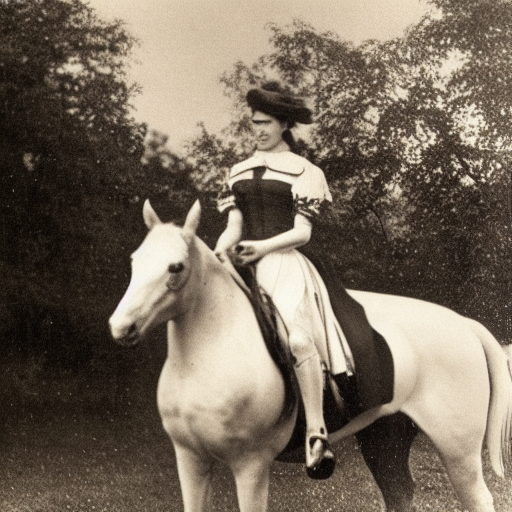

In [56]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image